In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

1.0
0.0


In [5]:
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) 
print(X_val.shape)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


【問題1】2次元畳み込み層の作成

In [7]:
class Conv2d:
    """
    2次元畳み込み層クラス
    
    Parameters
    --------------
     initializer : インスタンス
         重みの初期化方法
     optimizer : インスタンス
         最適化手法
     filter_num : int
         フィルタの数
     C : int
         チャンネル数
     filter_size : int
         フィルタの大きさ(縦横同じ)
     stride : int
         ストライド数
     pad : int
        パディング数    

    Attributes
    -------------
    W : 次の形のndarray, shape (filter_num, C, filter_size)
        フィルタ
    B : 次の形のndarray, shape (filter_num)
        バイアス
    X : 次の形のndarray, shape (N, C, H ,W)
        入力データのコピー
    col : im2colの結果
    col_W : 展開したフィルタ

    dW : 次の形のndarray, shape (batch_size, n_output)
        Wに関する損失Lの勾配
    dB : 次の形のndarray, shape (batch_size, n_output)
        Bに関する損失Lの勾配
    """
    def __init__(self, initializer, optimizer, filter_num, C, filter_size, stride=1, pad=0):
        #ハイパーパラメータ
        self.optimizer = optimizer
        self.stride = stride
        self.pad = pad
        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_num=filter_num, C=C, filter_size=filter_size)
        self.B = initializer.B(filter_num)
        
        #インスタンス変数
        self.X = None #入力
        self.col = None #im2col
        self.col_W = None #展開したフィルタ
        
        
    def forward(self, X):
        """
        フォワード
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力データ
            
        Returns
        ---------
        A : 次の形のndarray, shape (N, C, out_h ,out_w)
            畳み込みした結果
        """
        #サイズを取得
        FN, C, FH, FW = self.W.shape #フィルター
        N, C, H, W = X.shape #サンプル
        
        #出力されるサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)
        
        #im2col
        self.col = self._im2col(X, FH, FW, self.stride, self.pad)
        
        #フィルタを展開
        self.col_W = self.W.reshape(FN, -1).T

        #畳み込み演算
        A = np.dot(self.col, self.col_W) + self.B
        A = A.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) 
        
        #バックワードで使う
        self.X = X
        
        return A


    def backward(self, dA):
        """
        Parameters
        --------------
        dA : 次の形のndarray, shape (N, C, out_h ,out_w)(プーリング後)
            Aに関する損失Lの勾配
        
        Returns
        ---------
        dX : 次の形のndarray, shape (N, C, H ,W)(プーリング後)
            Xに関する損失Lの勾配
        """        
        #フィルタサイズを取得
        FN, C, FH, FW = self.W.shape
        
        #順番を入れ替え
        dA = dA.transpose(0,2,3,1).reshape(-1, FN) 
        
        #逆伝播
        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(dA, self.col_W.T)
        
        #col2im
        dX = self._col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)        

        return dX
    
    
    def _im2col(self, X, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力データ
        FH : int
            フィルターの高さ
        FW : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
            
        Returns
        -------
        col : 2次元配列
        """
        #サイズを取得
        N, C, H, W = X.shape
        
        #出力されるサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)

        #パディング
        img = np.pad(X, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        
        #ゼロ配列を用意し、結果を格納
        col = np.zeros((N, C, FH, FW, out_h, out_w))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y: y_max: stride, x: x_max: stride]
        
        #位置変換、reshape
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)

        return col
    
    
    def _col2im(self, dcol, X_shape, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        dcol : Xに関する損失Lの勾配
            
        X_shape : shape
            入力データの形状
        FH : int
            フィルターの高さ
        FW : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        ----------
        col2imの結果
        """
        #入力データのサイズ
        N, C, H, W = X_shape

        #出力のサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)
        
        #reshape、位置変換
        dcol = dcol.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
        
        #ゼロ配列を用意し、結果を格納
        img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                img[:, :, y: y_max: stride, x: x_max: stride] += dcol[:, :, y, x, :, :]

        return img[:, :, pad: H + pad, pad: W + pad]
    
    
    def _out_shape(self, H, FH, W, FW):
        '''
        出力サイズを計算する関数
        
        Parameters
        --------------
        H : int
            高さ
        FH : int
            フィルターの高さ
        W : int
            幅
        FW : int
            フィルターの幅
            
        Returns
        ----------
        out_h : int
            出力するときの高さ
        out_w : int
            出力するときの幅
        '''
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        return out_h, out_w

【問題2】2次元畳み込み後の出力サイズ

In [8]:
def _out_shape(self, H, FH, W, FW):
    '''
    出力サイズを計算する関数
    
    Parameters
    --------------
    H : int
        高さ
    FH : int
        フィルターの高さ
    W : int
        幅
    FW : int
        フィルターの幅
            
    Returns
    ----------
    out_h : int
        出力するときの高さ
    out_w : int
        出力するときの幅
    '''
    out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
    out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
    return out_h, out_w

【問題3】最大プーリング層の作成

In [9]:
class MaxPool2D:
    '''
    2次元畳み込み層クラス
    Parameters
    --------------
     pool_h : int
         対象領域の高さ
     pool_w : int
         対象領域の幅
     filter_size : int
         フィルタの大きさ(縦横同じ)
     stride : int
         ストライド数
     pad : int
        パディング数    

    Attributes
    -------------
    X : 次の形のndarray, shape (N, C, H ,W)
        Xのコピー
    arg_max : 次の形のndarray, shape (N * out_h * out_w,)
        
    '''
    def __init__(self, pool_h=3, pool_w=3, stride=1, pad=0):
        #ハイパーパラメータ
        self.pool_h = pool_h #対象領域の高さ
        self.pool_w = pool_w #対象領域の幅
        self.stride = stride #ストライド数
        self.pad = pad #パディング数
        
        #インスタンス変数
        self.X = None #Xのコピー
        self.arg_max = None #

    def forward(self, X):
        """
        フォワード
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        -------
        out : 
            maxプーリングした結果

        """
        #サイズを取得
        N, C, H, W = X.shape
        
        #出力のサイズを取得
        out_h, out_w = self._out_shape(H, self.pool_h, W, self.pool_w)
        
        #im2col
        col = self._im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        #max_pooling
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        
        #配列を変換
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2) #(N, out_h, out_w, C)→(N, C, out_h, out_w)

        #バックワードで使用
        self.X = X
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        """
        Parameters
        ----------
        dout : 
            outに関する損失Lの勾配
        
        Returns
        -------
        dX : 2次元配列
            Xに関する損失Lの勾配
        """        
        #位置を変える
        dout = dout.transpose(0, 2, 3, 1)
        
        #col2im
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dX = self._col2im(dcol, self.X.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dX

    def _im2col(self, input_data, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        input_data : 次の形のndarray, shape (N, C, H ,W)
            (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
        filter_h : int
            フィルターの高さ
        filter_w : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        -------
        col : 2次元配列
        """
        #サイズを取得
        N, C, H, W = input_data.shape
        
        #出力されるサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)

        #パディング
        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        
        #ゼロ配列を用意し、結果を格納
        col = np.zeros((N, C, FH, FW, out_h, out_w))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y: y_max: stride, x: x_max: stride]

        #位置変換、reshape
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1) 

        return col
    
    
    def _col2im(self, col, input_shape, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        col : 
            
        input_shape : 
            入力データの形状（例：(10, 1, 28, 28)）
        FH : int
            フィルターの高さ
        FW : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        ---------
        col2imの結果
        """
        #サイズ
        N, C, H, W = input_shape

        #出力のサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)
        
        #reshape、位置変換
        col = col.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2) 

        #ゼロ配列を用意し、結果を格納
        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(FH):
            y_max = y + stride*out_h
            for x in range(FW):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
    
    
    def _out_shape(self, H, FH, W, FW):
        '''
        出力サイズを計算する関数

        Parameters
        --------------
        H : int
            高さ
        FH : int
            フィルターの高さ
        W : int
            幅
        FW : int
            フィルターの幅

        Returns
        ----------
        out_h : int
            出力するときの高さ
        out_w : int
            出力するときの幅
        '''
        out_h = 1 + int((H - FH) / self.stride)
        out_w = 1 + int((W- FW) / self.stride)
        
        return out_h, out_w

【問題4】平滑化

In [10]:
class Flatten():
    '''
    平滑化を行うクラス
    
    Attribute
    -----------
    X : 次の形のndarray, shape (N, C, H ,W)
        入力
    '''
    def __init__(self):
        self.X_shape = None
    
    def forward(self, X):
        '''
        フォワード

        Parameters
        -------------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        ----------
        X_1d : 次の形のndarray, shape (N, C, H ,W)
        '''
        #1次元にする
        X_1d = X.reshape(X.shape[0], -1)
        
        #shapeを記録
        self.X_shape = X.shape
        
        return X_1d
    

    def backward(self, X):
        '''
        バックワード

        Parameters
        -------------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
        '''
        #shapeを戻す
        X = X.reshape(self.X_shape)
        
        return X

【問題5】学習・推定

In [11]:
import numpy as np

class ScratchDeepNeuralNetrowkClassifier():
    """
    ニューラルネットワーク分類器

    Parameters
    --------------
    epoc : int
        エポック数
    activaiton : {'sigmoid', 'tanh', 'relu'} default 'relu'
        活性化関数の種類
    solver :  {'sgd', 'adagrad'}, default 'adam'
        最適化手法の種類
    alpha : float
        学習率
    batch_size : int
        バッチサイズ
    initial : {'simple', 'xavier', 'he'} default 'he'
        重みの初期化方法
    sigma : float
        重みパラメータ(ガウス分布の標準偏差)
    n_nodes1 : int
        1層目の数
    n_nodes2 : int
        2層目の数
    n_output : int
        出力層の数
    verbose : bool
        学習過程の出力の有無
        
    Attributes
    -------------
    conv1, 2, 3 : インスタンス
        畳み込み層のインスタンス
    pool1, 2 : インスタンス
        プーリング層のインスタンス
    FC1, 2 : インスタンス
        結合層のインスタンス
    activation1, 2, 3 : インスタンス
        活性化関数のインスタンス
    flat : インスタンス
        平滑化するインスタンス
    loss_list : list
        学習用データの損失を記録するリスト
    mini_loss_list : list
        バッチサイズごとの学習用データの損失を記録するリスト
    val_loss_list : list
        検証用データの損失を記録するリスト
    mini_val_loss_list : list
        バッチサイズごとの検証用データの損失を記録するリスト
    """
    def __init__(self, epoc=10, activation='relu', solver='sgd', alpha=0.005,
                             batch_size=20, initial='he', sigma=0.005, n_nodes1=200, 
                             n_nodes2=100, filter_num=3,  filter_size=3, verbose=True, 
                            stride=1, pad=0):
        #ハイパーパラメータ 
        self.epoc            = epoc              #エポック数
        self.activation   = activation     #活性化関数
        self.solver          = solver            #最適化の手法
        self.alpha           = alpha             #学習率
        self.batch_size = batch_size   #バッチサイズ
        self.initial           = initial             #重みの初期化方法
        self.sigma          = sigma            #重みパラメータ
        self.n_nodes1   = n_nodes1    #1層目のノード数
        self.n_nodes2   = n_nodes2    #2層目のノード数
        self.filter_num  = filter_num    #フィルタの数
        self.filter_size   = filter_size    #フィルタのサイズ
        self.verbose      = verbose        #学習過程の出力(True : 有, False : 無)
        self.stride          = stride           #ストライド
        self.pad             = pad               #パディング
        
        #インスタンス変数
        self.conv1 = None #畳み込み層のインスタンス
        self.conv2 = None #畳み込み層のインスタンス
        self.conv3 = None #畳み込み層のインスタンス
        self.pool1  = None #プーリング層のインスタンス
        self.pool2  = None #プーリング層のインスタンス
        self.FC1     = None #結合層のインスタンス
        self.FC2     = None #結合層のインスタンス
        self.activation1            = None #活性化関数のインスタンス
        self.activation2             = None #活性化関数のインスタンス
        self.activation3             = None #活性化関数のインスタンス
        self.flat                           = None #平滑化するインスタンス
        self.loss_list                  = None #学習用データの損失を記録する配列
        self.mini_loss_list         = None #バッチサイズごとの学習用データの損失を記録する配列
        self.val_loss_list           = None #検証用データの損失を記録する配列
        self.mini_val_loss_list = None #バッチサイズごとの検証用データの損失を記録する配列

    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #1次元なら2次元にする
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if y.ndim == 1:
            y = y[:, np.newaxis]
            
        #one_hotエンコーディング
        n_output = np.unique(y).shape[0]
        y_onehot = self._one_hot(y, n_output)
        
        #ミニバッチを取得するクラスをインスタンス化
        train_mini_batch = GetMiniBatch(X, y_onehot, self.batch_size)
        
        #valがあるとき
        if X_val is not None and y_val is not None:
            
            #1次元なら2次元にする
            if X.ndim == 1:
                X_val = X_val[:, np.newaxis]
            if y_val.ndim == 1:
                y_val = y_val[:, np.newaxis]
            
            #one-hotエンコーディング
            y_val_onehot = self._one_hot(y_val, n_output) 
            
            #インスタンス化
            test_mini_batch = GetMiniBatch(X_val, y_val_onehot)
        
        #活性化関数の選択
        if self.activation == 'sigmoid':
            activate1 = Sigmoid()
            activate2 = Sigmoid()
            activate3 = Sigmoid()
            activate4 = Sigmoid()
        elif self.activation == 'tanh':
            activate1 = Tanh()
            activate2 = Tanh()
            activate3 = Tanh()
            activate4 = Tanh()
        elif self.activation == 'relu':
            activate1 = Relu()
            activate2 = Relu()
            activate3 = Relu()
            activate4 = Relu()
        
        #最適化手法の選択
        if self.solver == 'sgd':
            optimizer1 = SGD(self.alpha)
            optimizer2 = SGD(self.alpha)
            optimizer3 = SGD(self.alpha) 
            optimizer4 = SGD(self.alpha)
            optimizer5 = SGD(self.alpha) 
        elif self.solver == 'adagrad':
            optimizer1 = AdaGrad(self.alpha)
            optimizer2 = AdaGrad(self.alpha)
            optimizer3 = AdaGrad(self.alpha)
            optimizer4 = AdaGrad(self.alpha)
            optimizer5 = AdaGrad(self.alpha)
            
        #重みの初期化方法の選択
        if self.initial == 'simple':
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
            initializer4 = SimpleInitializer(self.sigma)
            initializer5 = SimpleInitializer(self.sigma)
        elif self.initial == 'xavier':
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
            initializer4 = XavierInitializer()
            initializer5 = XavierInitializer()
        elif self.initial == 'he':
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
            initializer4 = HeInitializer()
            initializer5 = HeInitializer()        

        #畳み込み層および活性化関数クラスのインスタンス化
        self.conv1 = Conv2d(initializer1, optimizer1, self.filter_num, X.shape[1], self.filter_size)
        self.activation1 = activate1
        self.pool1 = MaxPool2D()
        self.conv2 = Conv2d(initializer2, optimizer2, self.filter_num, self.filter_num, self.filter_size)
        self.activation2 = activate2
        self.pool2 = MaxPool2D()
        self.conv3 = Conv2d(initializer3, optimizer3, self.filter_num, self.filter_num, self.filter_size)
        self.activation3 = activate3
        
        #平滑化クラスのインスタンス化
        self.flat = Flatten()
        
        #全結合前のサイズ
        OH, OW = self._out_shape(X.shape[2], self.filter_size, X.shape[3], self.filter_size, 'conv')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'pool')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'conv')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'pool')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'conv')
        size = OH * OW * self.filter_num
        
        #結合層および活性化関数クラスのインスタンス化
        self.FC1 = FC(size, self.n_nodes1, initializer4, optimizer4) 
        self.activation4 = activate4
        self.FC2 = FC(self.n_nodes1, y_onehot.shape[1], initializer5, optimizer5) 
        self.activation5 = Softmax()

        #損失を記録するリスト(エポックごと)
        self.loss_list = []
        self.val_loss_list= []
        
        #エポック数だけ繰り返す
        for i in range(self.epoc):
            
            #損失を記録するリスト(イテレーション)
            self.mini_loss_list = []
            
            #イテレーション数実行
            for mini_X_train, mini_y_train in train_mini_batch:
                
                #フォワード
                self._forward(mini_X_train)
                
                #バックワード
                #全結合層
                dA5, mini_loss = self.activation5.backward(mini_y_train) 
                dZ4 = self.FC2.backward(dA5)          
                dA4 = self.activation4.backward(dZ4) 
                dZ3 = self.FC1.backward(dA4)            
                
                #shapeを戻す
                dZ3 = self.flat.backward(dZ3)
                
                #畳み込み層
                dA3 = self.activation3.backward(dZ3)
                dP2 = self.conv3.backward(dA3)
                dZ2 = self.pool2.backward(dP2)
                dA2 = self.activation2.backward(dZ2)
                dP1 = self.conv2.backward(dA2)
                dZ1 = self.pool1.backward(dP1)
                dA1 = self.activation1.backward(dZ1)
                dX = self.conv1.backward(dA1)   
                
                #イテレーションごとの損失をリストに格納
                self.mini_loss_list.append(mini_loss)

            #1エポックの損失をリストに格納
            loss = np.mean(self.mini_loss_list)
            self.loss_list.append(loss)

            #valがあるときもイテレーション数実行
            if X_val is not None and y_val is not None:
                
                self.mini_val_loss_list = []
                for mini_X_val, mini_y_val in test_mini_batch:
                    
                    #確率を予測
                    self._forward(mini_X_val)

                    #損失を計算
                    _, mini_val_loss = self.activation5.backward(mini_y_val) 
                    
                    #イテレーションごとの損失をリストに格納
                    self.mini_val_loss_list.append(mini_val_loss)

                #1エポックの損失をリストに格納
                val_loss = np.mean(self.mini_val_loss_list)
                self.val_loss_list.append(val_loss)

            #学習過程を出力する場合
            if self.verbose == True:
                print('学習用データの学習過程' + str(i + 1) + 'epoc目 : ' + str(self.loss_list[i]))

                #検証用データあり
                if X_val is not None or y_val is not None:
                    print('検証用データの学習過程' + str(i + 1) + 'epoc目 : ' + str(self.val_loss_list[i]))
                    
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        y_pred = self._forward(X)
        
        return np.argmax(y_pred, axis=1)
            

    def _one_hot(self, y, n_output):
        '''
        one-hotエンコーディングを行う関数
       
       Parameters
        ---------------
        y : 次の形のndarray, shape (n_features, 1)
            正解ラベルのベクトル
        n_output : int
            正解ラベルのユニーク値
            
        Returns
        ----------
        one_hot.T : 次の形のndarray, shape (n_features, n_output)
        '''
        #0配列を用意
        one_hot = np.zeros((n_output, y.shape[0]))
        
        #0配列の該当する位置に1を挿入
        for idx, val in enumerate(y.astype(int)):
            one_hot[val, idx] = 1

        return one_hot.T        
    
    
    def _forward(self, X):
        '''
        フォワードプロバケーション
        
        Parameters
        --------------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データ
        
        Returns
        ---------
        Z5 : 次の形のndarray, shape (n_samples, n_output)
            フォワードの結果
        '''
        #畳み込み(1層目)
        A1 = self.conv1.forward(X) 
        Z1 = self.activation1.forward(A1)    
        P1 = self.pool1.forward(Z1)

        #畳み込み(2層目)  
        A2 = self.conv2.forward(P1) 
        Z2 = self.activation2.forward(A2)                
        P2 = self.pool2.forward(Z2)           
                
        #畳み込み(3層目)  
        A3 = self.conv3.forward(P2) 
        Z3 = self.activation3.forward(A3)  

        #平滑化
        Z3 = self.flat.forward(Z3)
    
        #全結合層
        A4 = self.FC1.forward(Z3)                   
        Z4 = self.activation4.forward(A4) 
        A5 = self.FC2.forward(Z4)             
        Z5 = self.activation5.forward(A5)
        
        return Z5
    
    
    def _out_shape(self, H, FH, W, FW, layer):
        '''
        出力サイズを計算する関数
        
        Parameters
        --------------
        H : int
            高さ
        FH : int
            フィルターの高さ
        W : int
            幅
        FW : int
            フィルターの幅
        layer : str
            層の名前(conv or pool)
            
        Returns
        ----------
        out_h : int
            出力するときの高さ
        out_w : int
            出力するときの幅
        '''
        if layer == 'conv':
            out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
            out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        elif layer == 'pool':
            out_h = 1 + int((H - FH) / self.stride)
            out_w = 1 + int((W - FW) / self.stride)
        
        return out_h, out_w

In [12]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [13]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : インスタンス
        初期化方法のインスタンス
    optimizer : インスタンス
        最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer #最適化手法
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    
    def forward(self, Z1):
        """
        フォワードプロバケーション
        Parameters
        ----------
        Z1 : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
            
        Returns
        ----------
        Z2 : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.Z = Z1.copy()
        
        #バイアスと重みを結合
        Z2 = np.dot(Z1, self.W) + self.B
        
        return Z2
    
    
    def backward(self, dA):
        """
        バックプロバケーション
        Parameters
        ----------
        dA : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
            
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        #Zに関する損失の勾配を計算
        self.dB = dA 
        self.dW = np.dot(self.Z.T, dA) 
        dZ = np.dot(dA, self.W.T) 
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        
        return dZ

In [14]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma #重みパラメータ
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
            前の層のノード数
        n_nodes2 : int
            後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルターのサイズ(縦横同じ)

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み
        if filter_num is not None and C is not None and filter_size is not None:
            W =  self.sigma * np.random.randn(filter_num, C, filter_size, filter_size) 
       
        #全結合
        if n_nodes1 is not None and n_nodes2 is not None:
            W =  self.sigma * np.random.randn(n_nodes1, n_nodes2) 

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数

        Returns
        ----------
        B :次の形のndarray, shape (n_nodes2)
            バイアス
        """
        B = np.zeros(n_nodes2)
        
        return B

In [15]:
class XavierInitializer:
    """
    Xavierの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルタサイズ
        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み層
        if filter_num and C and filter_size is not None:
            W =  np.random.randn(filter_num, C, filter_size, filter_size) / np.sqrt(filter/num) 
        
        #全結合層
        else:
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) 
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) 
        
        return B

In [16]:
class HeInitializer:
    """
    Heの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルタサイズ
        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み層
        if filter_num and C and filter_size is not None:
            W = np.random.randn(filter_num, C, filter_size, filter_size) * np.sqrt(2 / filter_num)
       
        #全結合層
        else:
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) 
        
        return B

In [17]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    alpha : float
        学習率
    """
    def __init__(self, alpha):
        self.alpha = alpha #学習率
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #バッチサイズで割る
        layer.W -= self.alpha* layer.dW / layer.dB.shape[0] #(n_nodes1, n_nodes2)
        layer.B -= self.alpha* layer.dB.mean(axis=0) #(n_nodes2)
        
        return layer

In [18]:
class AdaGrad:
    """
    AdaGradの最適化のクラス
    Parameters
    ----------
    alpha : 学習率
    
    Attributes
    -------------
    H_W : ndarray
        前のイテレーションまでの重みの勾配の二乗和
    H_B : ndarray
        前のイテレーションまでのバイアスの勾配の二乗和
    """
    def __init__(self, alpha):
        #ハイパーパラメータ
        self.alpha = alpha #学習率
        
        #インスタンス変数
        self.H_W= None #重みの勾配の二乗和の配列
        self.H_B = None #バイアスの勾配の二乗和の配列
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #self.Hの初期化
        if self.H_W is None:
            self.H_W = np.zeros(layer.W.shape)
        if self.H_B is None:
            self.H_B = np.zeros(layer.B.shape)
        
        #更新    
        self.H_W += (layer.dW / layer.dB.shape[0]) ** 2 #重みの勾配の二乗和
        self.H_B += (layer.dB.mean(axis=0)) ** 2 #バイアスの二乗和
        layer.W -= self.alpha / np.sqrt(self.H_W + 1e-7) * layer.dW / layer.dB.shape[0] #重み
        layer.B -= self.alpha / np.sqrt(self.H_B + 1e-7) * layer.dB.mean(axis=0) #バイアス 
        
        return layer

In [19]:
class Sigmoid:
    '''
    シグモイド関数のクラス
    Attributes
    --------------
    Z : ndarray
        活性化関数を計算した配列
    '''
    def __init__(self):
        self.Z = None #活性化関数の配列
    

    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.Z = 1 / (1 + np.exp(-A)) 
        
        return self.Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        dA = dZ * (1 - self.Z) * self.Z
        
        return dA

In [20]:
class Tanh:
    '''
    ハイパポリックタンジェント関数のクラス
    Attributes
    --------------
    Z : ndarray
        活性化関数を計算した配列
    '''
    def __init__(self):
        self.Z = None #活性化関数の配列

    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.Z =  np.tanh(A)
        
        return  self.Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        dA = dZ * (1 - self.Z**2)
        
        return dA

In [21]:
class Relu:
    '''
    ReLU関数のクラス
    Attributes
    --------------
    X : ndarray
        特徴量ベクトルと重みとバイアスを計算した配列
    '''
    def __init__(self):
        self.X = None #特徴量ベクトルと重みとバイアスを計算した配列

    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.X = A.copy()
        
        #Aが0以下なら0にする
        Z = np.maximum(0, A)
        
        return Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        #forwardで0以下の部分を0にする
        dA = np.where(self.X > 0, dZ, 0)

        return dA

In [22]:
class Softmax:
    '''
    ソフトマックス関数のクラス
    Attributes
    --------------
    Z : ndarray
        活性化関数を計算した配列
    '''
    def __init__(self):
        self.Z = None #活性化関数の配列
    
    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_output)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_output)
            ソフトマックス関数の計算結果
        '''
        #オーバーフロー対策
        c = np.max(A)
        exp_A = np.exp(A - c)
        
        #分母
        sum_exp_A = np.sum(exp_A, axis=1).reshape(-1, 1)

        self.Z = exp_A / sum_exp_A
        
        return self.Z

    
    def backward(self, y):
        '''
        バックプロバケーション
        Parameters
        --------------
        y : 次の形のndarray, shape (batch_size, n_output)
            正解ラベルのベクトル
        Z : 次の形のndarray, shape (batch_size, n_output)
            フォワードプロバケーションの出力
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        #交差エントロピー誤差の計算
        loss_sum = np.sum(y * np.log(self.Z), axis=1)
        loss = -np.mean(loss_sum)
        
        #勾配の計算
        dA = self.Z - y
        
        return dA, loss

In [23]:
cls = ScratchDeepNeuralNetrowkClassifier()
cls.fit(X_train, y_train, X_val, y_val)

/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


学習用データの学習過程1epoc目 : 1.4661201790748366
検証用データの学習過程1epoc目 : 0.4226224984662115
学習用データの学習過程2epoc目 : 0.30599117408409304
検証用データの学習過程2epoc目 : 0.2204509178785726
学習用データの学習過程3epoc目 : 0.17315741637528193
検証用データの学習過程3epoc目 : 0.15004261485137027
学習用データの学習過程4epoc目 : 0.1243405834651521
検証用データの学習過程4epoc目 : 0.11998272780652362
学習用データの学習過程5epoc目 : 0.09763284663224704
検証用データの学習過程5epoc目 : 0.10738177056682502
学習用データの学習過程6epoc目 : 0.08117545936183822
検証用データの学習過程6epoc目 : 0.10147065341633756
学習用データの学習過程7epoc目 : 0.06929330858847363
検証用データの学習過程7epoc目 : 0.0978032108263872
学習用データの学習過程8epoc目 : 0.059707411079146296
検証用データの学習過程8epoc目 : 0.09507979263585886
学習用データの学習過程9epoc目 : 0.0511235734228801
検証用データの学習過程9epoc目 : 0.10022548581853796
学習用データの学習過程10epoc目 : 0.04369760996055971
検証用データの学習過程10epoc目 : 0.09871846218279286


In [24]:
y_pred = cls.predict(X_test)

In [25]:
def cost_curve(loss, val_loss):
    '''
    学習曲線を出力する関数
    '''
    plt.plot(loss)
    plt.plot(val_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title('Cost curve')
    plt.show()

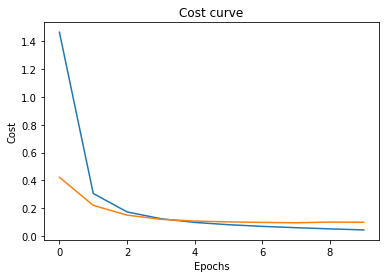

In [26]:
cost_curve(cls.loss_list, cls.val_loss_list)

In [27]:
def evalution(y_test, y_pred):
    '''
     分類問題の指標値を出力する関数
 
     Paraeters
     -------------
    y_test : 次の形のndarray, shape (n_samples, )
        正解値
    y_pred : 次の形のndarray, shape (n_samples, )
        予測したラベル
    '''
    #accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy :', accuracy)

    #precision
    precision = precision_score(y_test, y_pred, average='macro')
    print('precision :', precision)

    #recall
    recall = recall_score(y_test, y_pred, average='macro')
    print('recall :', recall)

    #f1
    f1 = f1_score(y_test, y_pred, average='macro')
    print('f1 :', f1)

In [28]:
evalution(y_test, y_pred)

accuracy : 0.9716
precision : 0.9716497969647291
recall : 0.9713335668904779
f1 : 0.9714543604395797


【問題10】出力サイズとパラメータ数の計算

In [29]:
def calc_outshape_parameter(H, FH, W, FW, FN, P, S, IC):
    '''
    出力サイズとパラメータを計算する関数

    Parameters
    --------------
    H : int
        高さ
    FH : int
        フィルターの高さ
    W : int
        幅
    FW : int
        フィルターの幅
    FN : int
        フィルタ数
    P : int
        パディング
    S : int
        ストライド
    IC : int
        入力のチャンネル数

    Returns
    ----------
    out_h : int
        出力の高さ
    out_w : int
        出力の幅
    parameter : int 
        パラメータ
    '''
    out_h = int((H + 2 * P - FH) / S) + 1
    out_w = int((W + 2 * P - FW) / S) + 1
    parameter = FH * FW * IC * FN + FN
        
    return out_h, out_w, parameter

In [30]:
#入力サイズ
H, W, IC = (144, 144, 3)

#フィルタサイズ
FH, FW, _ = (3, 3, 3)

#フィルタ数
FN = 2

#ストライド
S = 1

#パディング
P = 0

#計算
OH, OW, parameter = calc_outshape_parameter(H, FH, W, FW, FN, P, S, IC)

print('出力サイズ(OH × OW × FN) : {} × {} × {}'.format(OH, OW, FN))
print('パラメータ : {}'.format(parameter))

出力サイズ(OH × OW × FN) : 142 × 142 × 2
パラメータ : 56


In [31]:
#入力サイズ
H, W, IC = (60, 60, 24)

#フィルタサイズ
FH, FW, _ = (3, 3, 24)

#フィルタ数
FN = 2

#ストライド
S = 1

#パディング
P = 0

#計算
OH, OW, parameter = calc_outshape_parameter(H, FH, W, FW, FN, P, S, IC)

print('出力サイズ(OH × OW × FN) : {} × {} × {}'.format(OH, OW, FN))
print('パラメータ : {}'.format(parameter))

出力サイズ(OH × OW × FN) : 58 × 58 × 2
パラメータ : 434


In [32]:
#入力サイズ
H, W, IC = (20, 20, 10)

#フィルタサイズ
FH, FW, _ = (3, 3, 10)

#フィルタ数
FN = 2

#ストライド
S = 2

#パディング
P = 0

#計算
OH, OW, parameter = calc_outshape_parameter(H, FH, W, FW, FN, P, S, IC)

print('出力サイズ(OH × OW × FN) : {} × {} × {}'.format(OH, OW, FN))
print('パラメータ : {}'.format(parameter))

出力サイズ(OH × OW × FN) : 9 × 9 × 2
パラメータ : 182
